In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
opj = os.path.join
import numpy as np
import yaml
import pickle
from datetime import datetime, timedelta
import time

try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
    from prfpy.fit import Iso2DGaussianFitter
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
    from prfpy_csenf.fit import Iso2DGaussianFitter

from dag_prf_utils.utils import *
from dag_prf_utils.prfpy_ts_plotter import TSPlotter
from dag_prf_utils.prfpy_functions import *
from scot_habrok.load_saved_info import *

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE, set using os.environ above
Error importing pycortex... Not a problem unless you want to use pycortex stuff
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [21]:
sub_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07']
model_list = ['gauss', 'css'] # , 'norm', 'dog']
fit_stage_list = ['grid']
hrf_ver_list = ['optimal' ] 
task_list = ['AS0']
look_in = 'prf_HRFfit_NM_dt5'

def nice_id(task, model, fit_stage, hrf_ver):
    return f'{task}_m{model[0]}_{fit_stage[:2]}_{hrf_ver[:2]}'

In [22]:
cut_vols = 5
prf_settings = {}
prf_settings['default'] = load_yml_settings('new')
for sub in sub_list:    
    prf_settings[sub] = load_yml_settings('optimal', sub)

design_matrix = get_design_matrix_npy('AS0')['AS0']
design_matrix = design_matrix[:,:,cut_vols:]

prf_stim = {}
prf_model = {}
for sub in ['default', *sub_list]:
    prf_stim[sub] = PRFStimulus2D(
        screen_size_cm=prf_settings[sub]['screen_size_cm'],          
        screen_distance_cm=prf_settings[sub]['screen_distance_cm'],  
        design_matrix=design_matrix,                            
        TR=prf_settings[sub]['TR'],                              
        )   
    prf_model[sub] = {}
    for model in model_list: 
        if 'gauss' in model:
            prf_model[sub][model] = Iso2DGaussianModel(
                stimulus=prf_stim[sub],                                  # The stimulus we made earlier
                hrf=prf_settings[sub]['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
                normalize_RFs=prf_settings[sub]['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
                )
        elif 'css' in model:
            prf_model[sub][model] = CSS_Iso2DGaussianModel(
                stimulus=prf_stim[sub],                                  # The stimulus we made earlier
                hrf=prf_settings[sub]['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
                normalize_RFs=prf_settings[sub]['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
                )            
        elif 'norm' in model:
            prf_model[sub][model] = Norm_Iso2DGaussianModel(
                stimulus=prf_stim[sub],                                  # The stimulus we made earlier
                hrf=prf_settings[sub]['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
                normalize_RFs=prf_settings[sub]['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
                )                       
        elif 'dog' in model:
            prf_model[sub][model] = DoG_Iso2DGaussianModel(
                stimulus=prf_stim[sub],                                  # The stimulus we made earlier
                hrf=prf_settings[sub]['hrf']['pars'],                    # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
                normalize_RFs=prf_settings[sub]['normalize_RFs'],        # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
                )                                   
            


Loading optimal HRF sub-01_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 3.642
Loading optimal HRF sub-02_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 7.479
Loading optimal HRF sub-03_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 6.188
Loading optimal HRF sub-04_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 5.169
Loading optimal HRF sub-05_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 2.34
Loading optimal HRF sub-06_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 4.134
Loading optimal HRF sub-07_model-gauss_roi-custom_task-AS0-fits_HRF-OPTIMAL.yml
Loading optimal HRF 6.861


In [24]:
# Load the prf params into nice objects
prf_multi = {}
for sub in sub_list:
    prf_objs = []   
    prf_ids = []
    # Load data for time series    
    ts_data = load_data_tc(
        sub=sub,
        task_list=task_list,
        look_in=look_in,
    )
    for task in task_list:
        for model in model_list:
            for fit_stage in fit_stage_list:
                for hrf_ver in hrf_ver_list:
                    # Create id name 
                    prf_ids.append(nice_id(task, model, fit_stage, hrf_ver))
                    # Load the data 
                    prf_data = load_data_prf(
                        sub=sub,
                        task_list=task,
                        model_list=model,
                        fit_stage=fit_stage,
                        include=hrf_ver,
                        look_in=look_in,
                        exclude='batch'
                    )[task][model]
                    # need subject specific model if optimal, else default
                    if hrf_ver == 'optimal':
                        this_mod = prf_model['default'][model]
                    else:
                        this_mod = prf_model[sub][model]
                    prf_objs.append(
                        TSPlotter(
                            prf_params=prf_data,
                            model=model, 
                            prfpy_model=this_mod,
                            real_ts=ts_data[task],
                            )
                    )        
    prf_multi[sub] = PrfMulti(prf_objs, prf_ids)

/scratch/p307263/pilot1/derivatives/prf_HRFfit_NM_dt5/sub-01/ses-1/sub-01_model-gauss_roi-all_hrf-optimal_task-AS0-fits_stage-grid_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True
/scratch/p307263/pilot1/derivatives/prf_HRFfit_NM_dt5/sub-01/ses-1/sub-01_model-css_roi-all_hrf-optimal_task-AS0-fits_stage-grid_desc-prf_params.pkl
prf_params.shape[-1]=9
include hrf = True
include rsq = True
/scratch/p307263/pilot1/derivatives/prf_HRFfit_NM_dt5/sub-02/ses-1/sub-02_model-gauss_roi-all_hrf-optimal_task-AS0-fits_stage-grid_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True
/scratch/p307263/pilot1/derivatives/prf_HRFfit_NM_dt5/sub-02/ses-1/sub-02_model-css_roi-all_hrf-optimal_task-AS0-fits_stage-grid_desc-prf_params.pkl
prf_params.shape[-1]=9
include hrf = True
include rsq = True
/scratch/p307263/pilot1/derivatives/prf_HRFfit_NM_dt5/sub-03/ses-1/sub-03_model-gauss_roi-all_hrf-optimal_task-AS0-fits_stage-grid_desc-prf_params.pkl
prf_p

In [25]:
print('rsq > 0.3 ecc < 5')
for sub in sub_list:
    roi_mask = load_roi(sub, 'custom', combine_matches=True)
    print('')
    print(f'{sub} nr vx in custom = {roi_mask.sum()}')
    for id in prf_multi[sub].id_list:
        vx_mask = prf_multi[sub].prf_obj[id].return_vx_mask(th={
            'min-rsq' : .3,
            'max-ecc' : 5, 
            'roi' : roi_mask,
        })
        rsq_masked = np.mean(prf_multi[sub].prf_obj[id].pd_params['rsq'][vx_mask])
        print(f'{id} ={vx_mask.mean()*100:.3f}  mean rsq = {rsq_masked:.3f}'  )

rsq > 0.3 ecc < 5

sub-01 nr vx in custom = 53939
AS0_mg_gr_op =2.152  mean rsq = 0.523
AS0_mc_gr_op =2.157  mean rsq = 0.529

sub-02 nr vx in custom = 32633
AS0_mg_gr_op =3.486  mean rsq = 0.521
AS0_mc_gr_op =3.535  mean rsq = 0.528

sub-03 nr vx in custom = 27154
AS0_mg_gr_op =3.414  mean rsq = 0.560
AS0_mc_gr_op =3.505  mean rsq = 0.563

sub-04 nr vx in custom = 36742
AS0_mg_gr_op =2.482  mean rsq = 0.473
AS0_mc_gr_op =2.521  mean rsq = 0.479

sub-05 nr vx in custom = 48362
AS0_mg_gr_op =2.904  mean rsq = 0.554
AS0_mc_gr_op =2.918  mean rsq = 0.561

sub-06 nr vx in custom = 59395
AS0_mg_gr_op =2.263  mean rsq = 0.497
AS0_mc_gr_op =2.294  mean rsq = 0.502

sub-07 nr vx in custom = 3581
AS0_mg_gr_op =0.845  mean rsq = 0.639
AS0_mc_gr_op =0.851  mean rsq = 0.653


Using fs dir = /scratch/p307263/pilot1/derivatives/freesurfer
Just using undersurface file..
No vx to mask
No vx to mask
Make RGB time = 0.05816149711608887
http://localhost:8000/


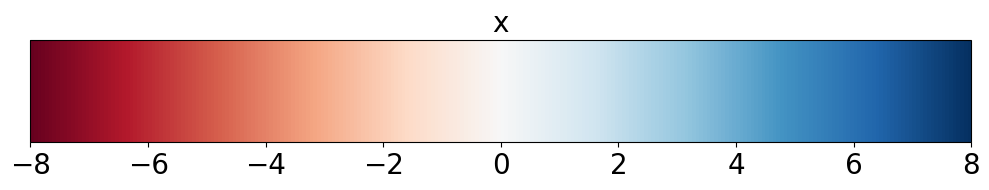

In [36]:
# from dag_prf_utils.auto_surf import dag_auto_from_prf_obj
# fs_dir = '/scratch/p307263/pilot1/derivatives/freesurfer'
# os.listdir(fs_dir)
# sub = sub_list[1]
# task = 'AS0'
# fs =  dag_auto_from_prf_obj(
#     prf_obj=prf_multi[sub].prf_obj['AS0_mc_gr_op'], 
#     sub=sub,
#     fs_dir=fs_dir,
#     open=True,
    
# )


In [35]:
fs.

In [33]:
prf_multi[sub].id_list

['AS0_mg_gr_op', 'AS0_mc_gr_op']

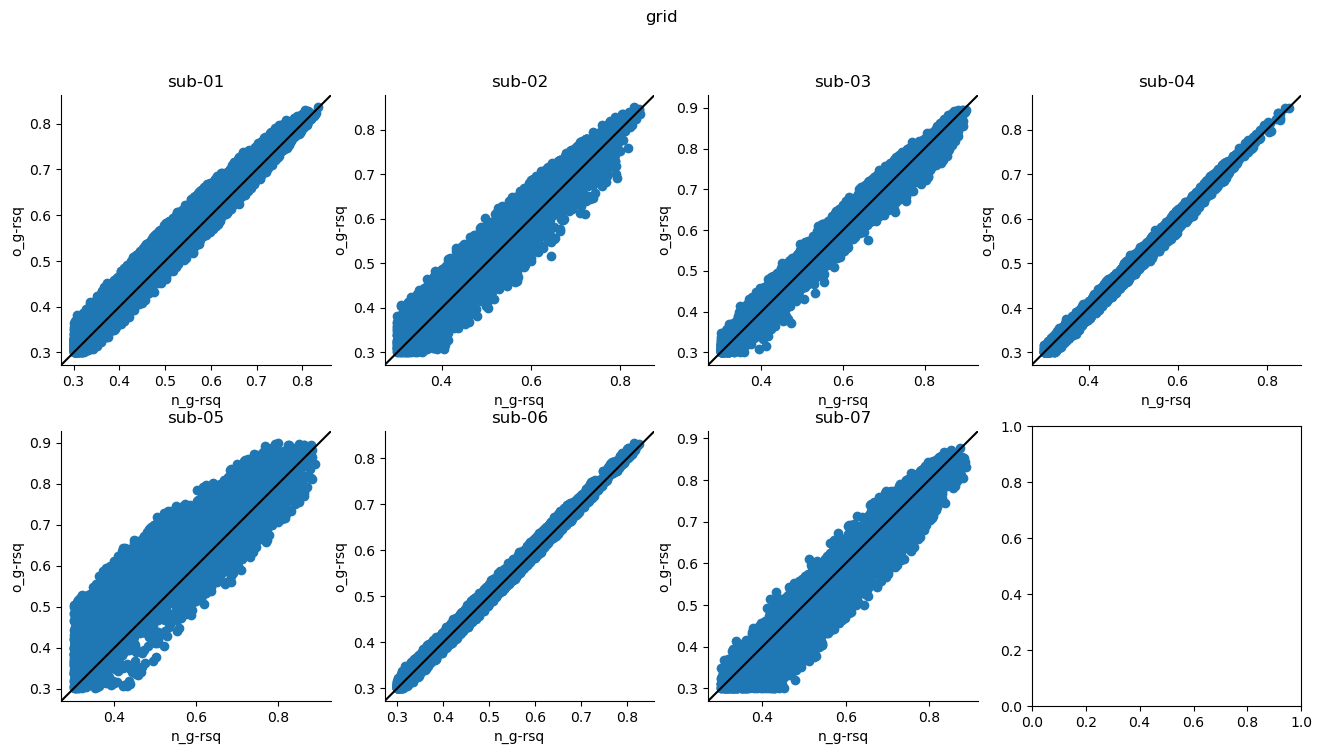

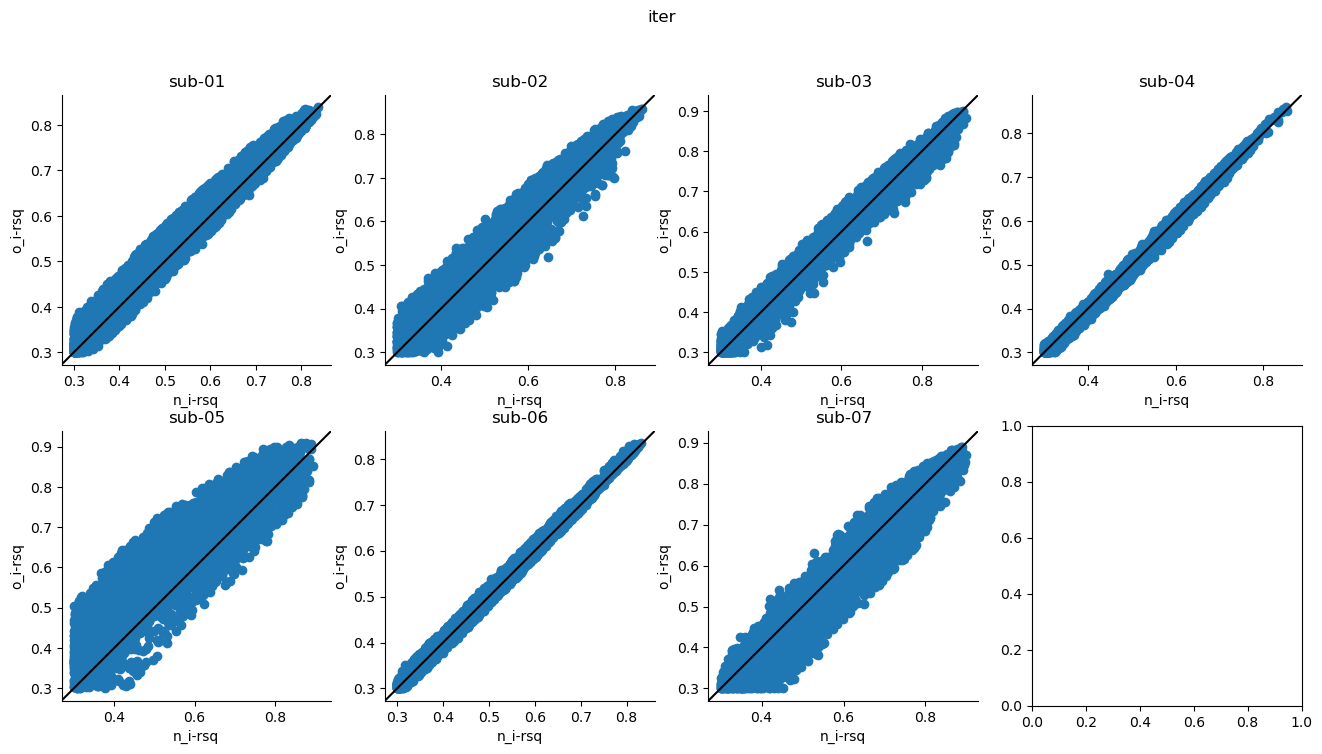

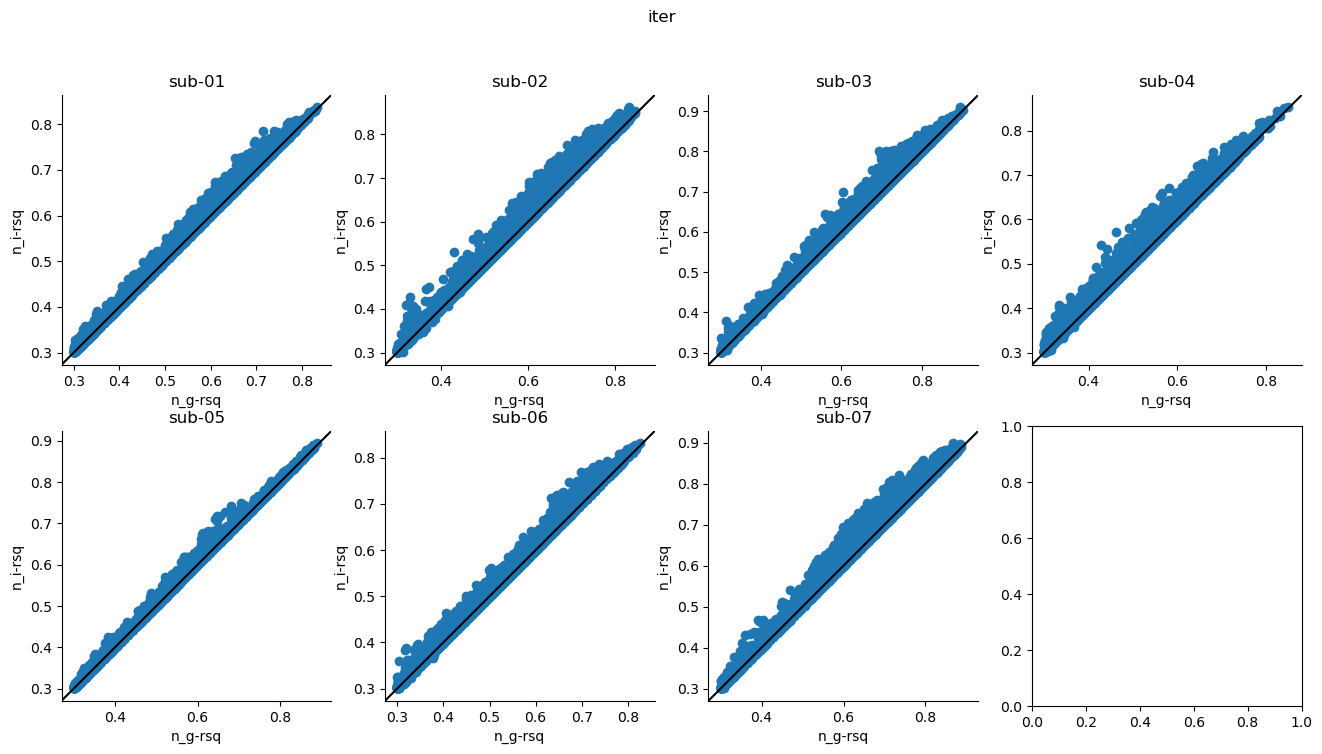

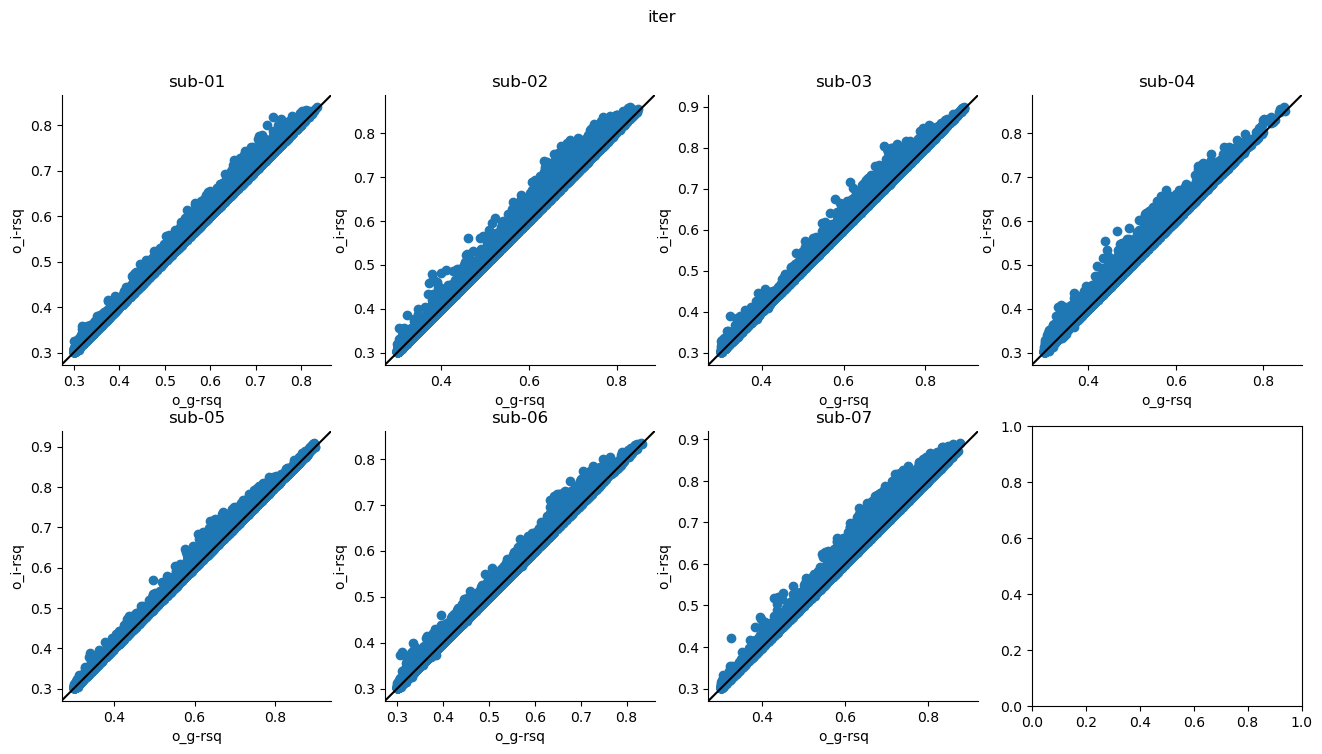

In [13]:
fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
fig.suptitle('grid')
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    prf_multi[sub].scatter(
        'n_g-rsq', 'o_g-rsq',
        th = {
            'n_g-min-rsq':.3,
            'o_g-min-rsq':.3,
            'n_g-max-ecc': 5,
            'o_g-max-ecc': 5,            
        },        
        do_id_line=True,
        ax = ax[iS], 
    )
    ax[iS].set_title(sub)

# iter
fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
fig.suptitle('iter')
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    prf_multi[sub].scatter(
        'n_i-rsq', 'o_i-rsq',
        th = {
            'n_i-min-rsq':.3,
            'o_i-min-rsq':.3,
            'n_i-max-ecc': 5,
            'o_i-max-ecc': 5,            
        },        
        do_id_line=True,
        ax = ax[iS], 
    )
    ax[iS].set_title(sub)



# iter
fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
fig.suptitle('iter')
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    prf_multi[sub].scatter(
        'n_g-rsq','n_i-rsq',
        th = {
            'n_i-min-rsq':.3,
            'n_g-min-rsq':.3,
            'n_i-max-ecc': 5,
            'n_g-max-ecc': 5,            
        },        
        do_id_line=True,
        ax = ax[iS], 
    )
    ax[iS].set_title(sub)


fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
fig.suptitle('iter')
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    prf_multi[sub].scatter(
        'o_g-rsq', 'o_i-rsq',
        th = {
            'o_g-min-rsq':.3,
            'o_i-min-rsq':.3,
            'o_g-max-ecc': 5,
            'o_i-max-ecc': 5,            
        },        
        do_id_line=True,
        ax = ax[iS], 
    )
    ax[iS].set_title(sub)

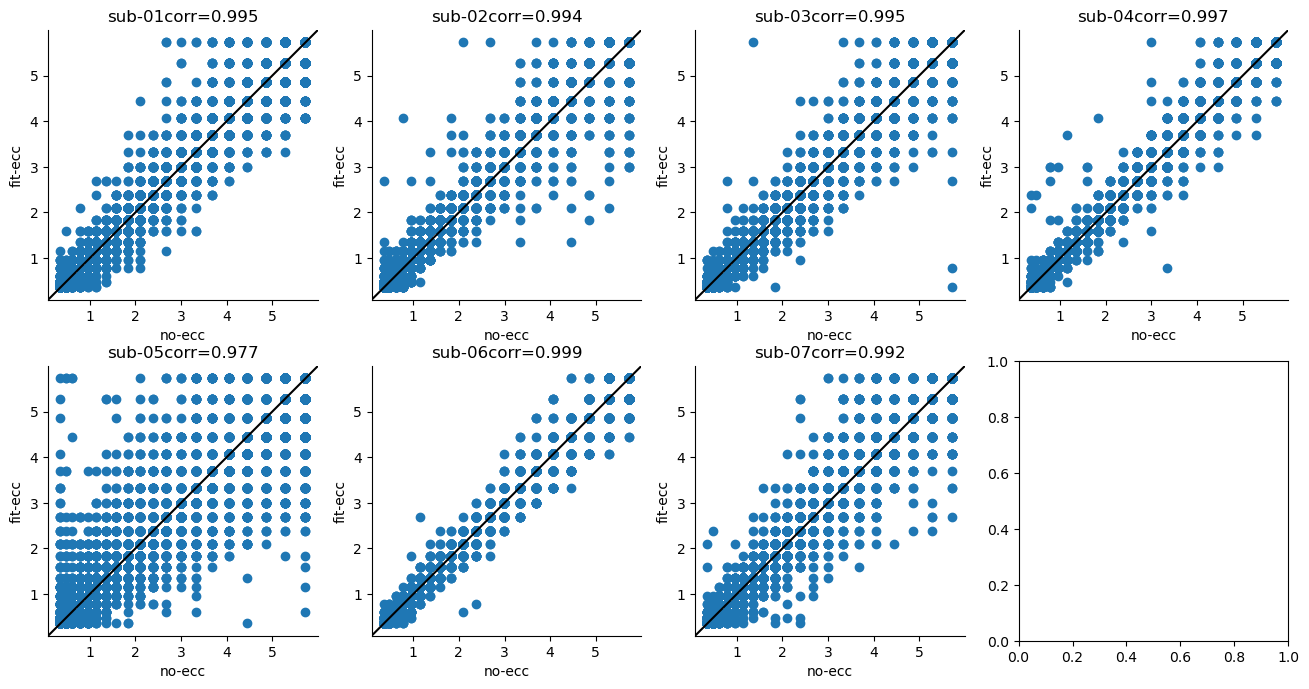

In [33]:
fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    ax[iS].set_title(sub)
    prf_multi[sub].scatter(
        'no-ecc', 'fit-ecc',
        do_id_line=True,
        min_rsq = 0.1, 
        ax = ax[iS], 
        do_corr=True,
    )

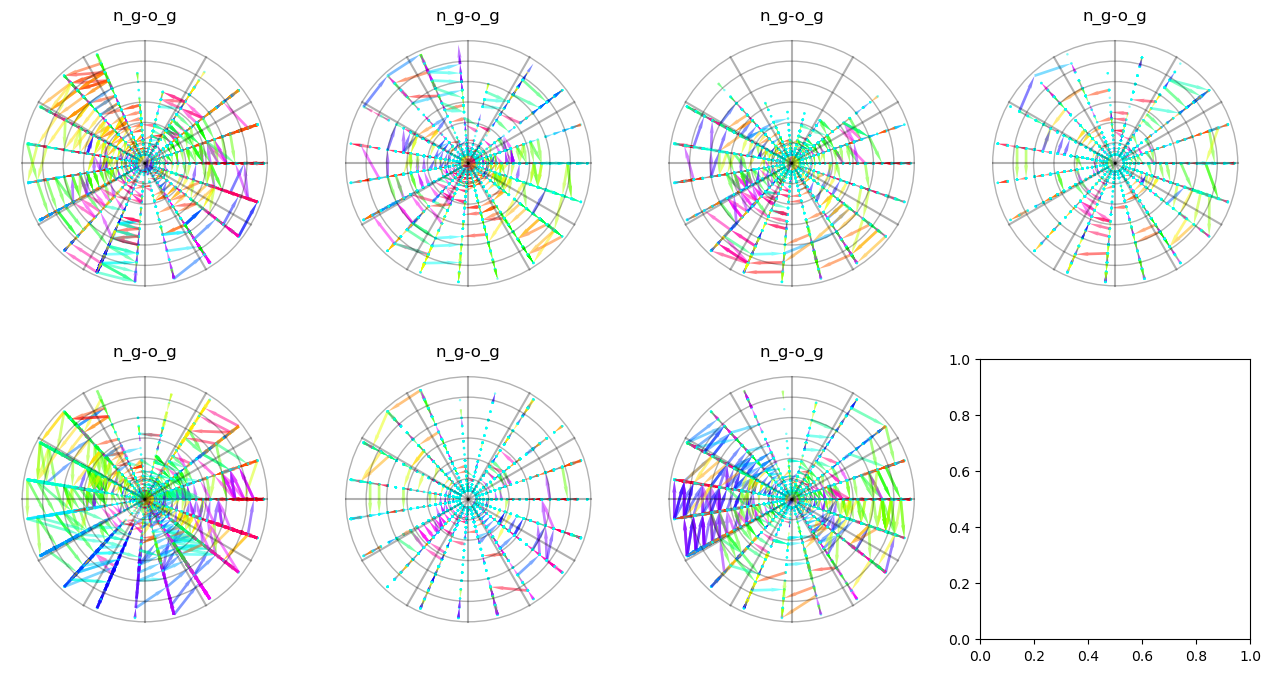

In [47]:
fig, ax = plt.subplots(2,4,figsize=(4*4,2*4))
ax = ax.flatten()
for iS,sub in enumerate(sub_list):
    ax[iS].set_title(sub)
    prf_multi[sub].arrow(
        'n_g', 'o_g',
        min_rsq = 0.3, 
        max_ecc = 5,
        ax = ax[iS], 
        arrow_col='angle',
        # do_binning=True, 
    )

In [4]:
sub_list = ['sub-01',]# 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06']
task_list = ['AS0', ] # 'AS1', 'AS2']
model_list = ['gauss', ] # 'norm']
# look_ins = ['prf_no_hrf', 'prf_nelder_mead']
look_ins = ['prf_NM_hrf4pt6_full', 'prf_NM_hrf4pt6_BL_full']
fitters = ['nelder', 'nelder'] # ['tc_', 'nelder']
prf_multi = {}
for sub in sub_list:
    prf_objs = []
    for look_in,fitter in zip(look_ins, fitters):
        for model in model_list:
            for task in task_list:
                ts_data = load_data_tc(
                    sub=sub,
                    task_list=task,
                    look_in=look_in,
                )[task]
                prf_data = load_data_prf(
                    sub=sub,
                    task_list=task,
                    model_list=model,
                    fit_stage='iter',
                    look_in=look_in,
                    include=fitter,
                    exclude='batch'
                )[task][model]
                prf_objs.append(
                    TSPlotter(
                        prf_params=prf_data,
                        model=model, 
                        prfpy_model=gg, #[i],
                        # real_ts=ts_data,
                        )
                )        
    prf_multi[sub] = PrfMulti(prf_objs, ['b0', 'bM'])



/scratch/p307263/pilot1/derivatives/prf_NM_hrf4pt6_full/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_COLLATED_stage-iter_constr-nelder_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True
MAKING UP A PRFPY STIMULUS FOR PLOTTING PURPOSE
/scratch/p307263/pilot1/derivatives/prf_NM_hrf4pt6_BL_full/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_COLLATED_stage-iter_constr-nelder_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True
MAKING UP A PRFPY STIMULUS FOR PLOTTING PURPOSE


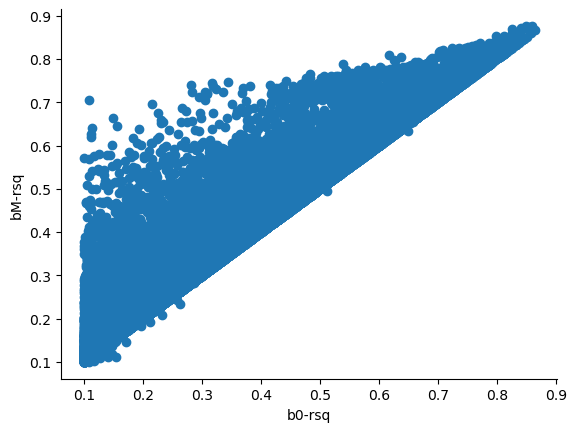

In [5]:
prf_multi[sub].scatter(
    'b0-rsq', 'bM-rsq'
)


In [7]:
prf_multi[sub].prf_obj['bM'].return_vx_mask({'min-rsq':.1}).mean()
prf_multi[sub].prf_obj['b0'].return_vx_mask({'min-rsq':.1}).mean()

0.07621544204373129

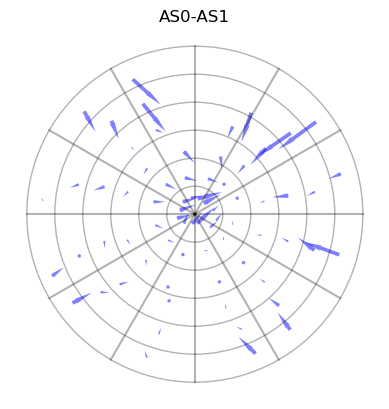

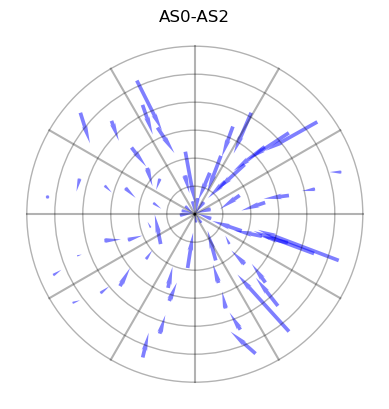

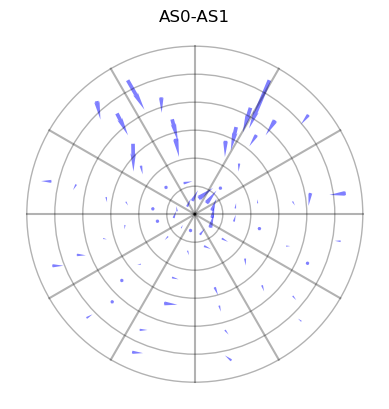

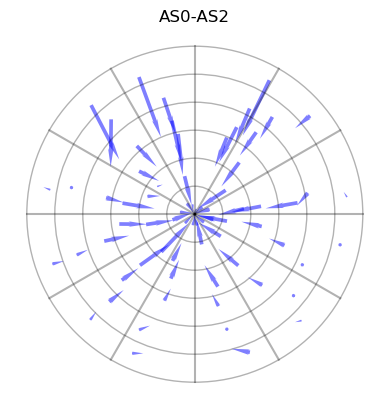

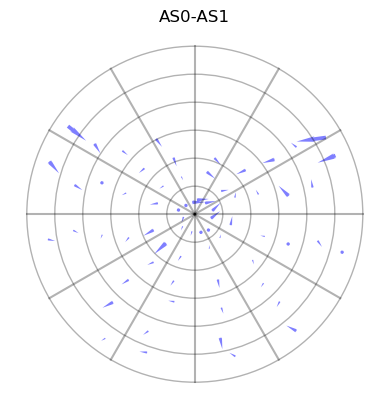

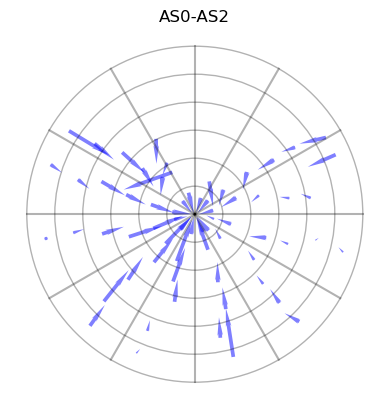

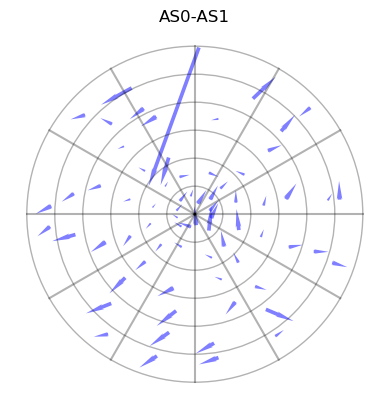

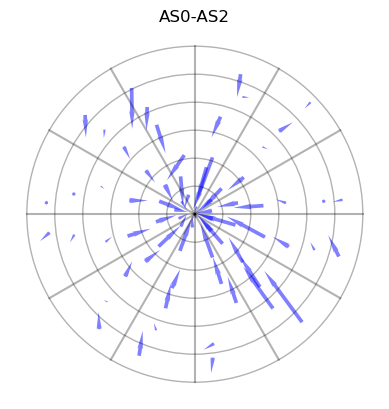

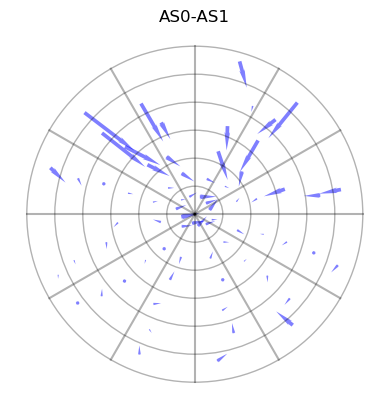

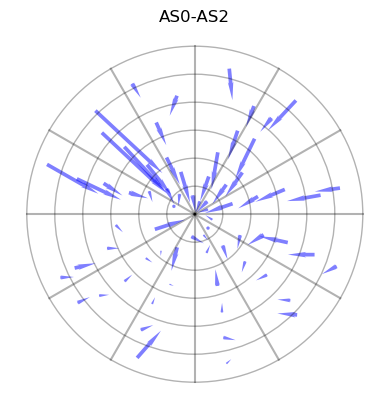

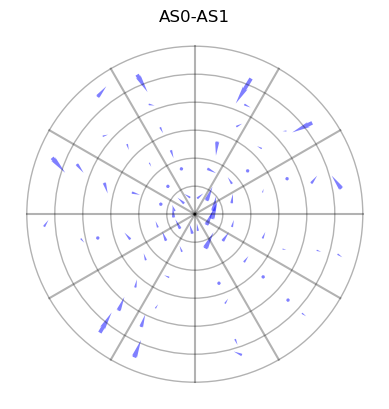

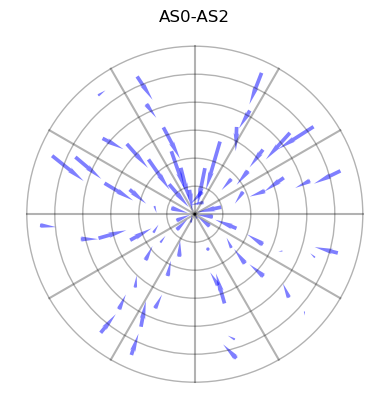

In [7]:
for sub in sub_list:
    for task in ['AS1', 'AS2']:
        plt.figure()
        prf_multi[sub].arrow(
            'AS0', task, min_rsq=0.3, 
            do_binning=True
        )
        # bloop

In [10]:
min_rsq = 0.01
max_ecc = 5
for sub in sub_list:
    pct_th_tc = prf_multi[sub].return_vx_mask({
        'tc-min-rsq':min_rsq,
        'tc-max-ecc':max_ecc,
        }).mean()*100
    pct_th_nm = prf_multi[sub].return_vx_mask({
        'nm-min-rsq':min_rsq,
        'nm-max-ecc':max_ecc,
        }).mean()*100
    
    print(f'{sub} diff tc nm > {min_rsq} = {pct_th_tc - pct_th_nm:.3f}')


sub-01 diff tc nm > 0.01 = -10.872
sub-02 diff tc nm > 0.01 = -12.965
sub-03 diff tc nm > 0.01 = -16.556
sub-04 diff tc nm > 0.01 = -16.255
sub-05 diff tc nm > 0.01 = -6.836
sub-06 diff tc nm > 0.01 = -13.707


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


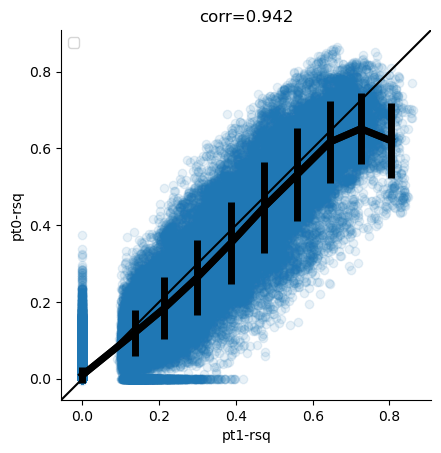

In [43]:
prf_multi[sub].scatter(
    'pt1-rsq', 'pt0-rsq', do_corr=True,
    min_rsq=0.1, dot_alpha=.1,
    th = {},
    # th_plus={'pt1-max-ecc':5,'pt0-max-ecc':5,}, 
    do_id_line=True, 
    # do_kde=True, 
    do_line=True,

)

{'all-min-rsq': 0.1, 'all-bound-ecc': [2, 3]}
{'all-min-rsq': 0.1, 'all-bound-ecc': [2, 3]}


<Figure size 1000x1000 with 0 Axes>

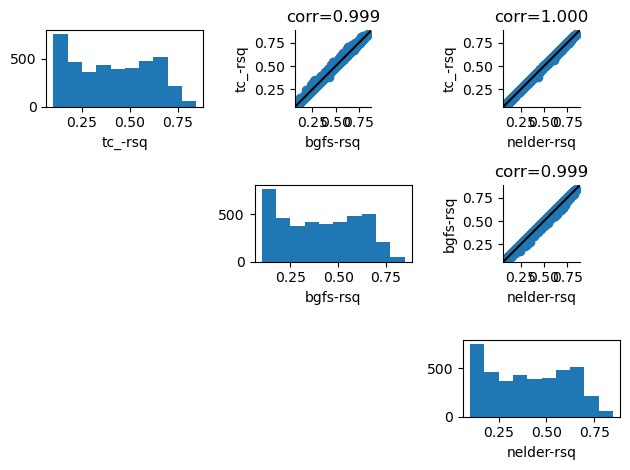

In [16]:
%matplotlib inline
for sub in sub_list:
    plt.figure(figsize=(10,10))
    prf_multi[sub].multi_scatter(
        [f'{i}-rsq' for i in fitters],
        do_id_line=True,  dag_scatter=True,
        th={'all-min-rsq':.1, 'all-bound-ecc':[2,3]},
        do_corr=True,
        #y_lim=[0,1],
        # dot_alpha=0.1,
    )

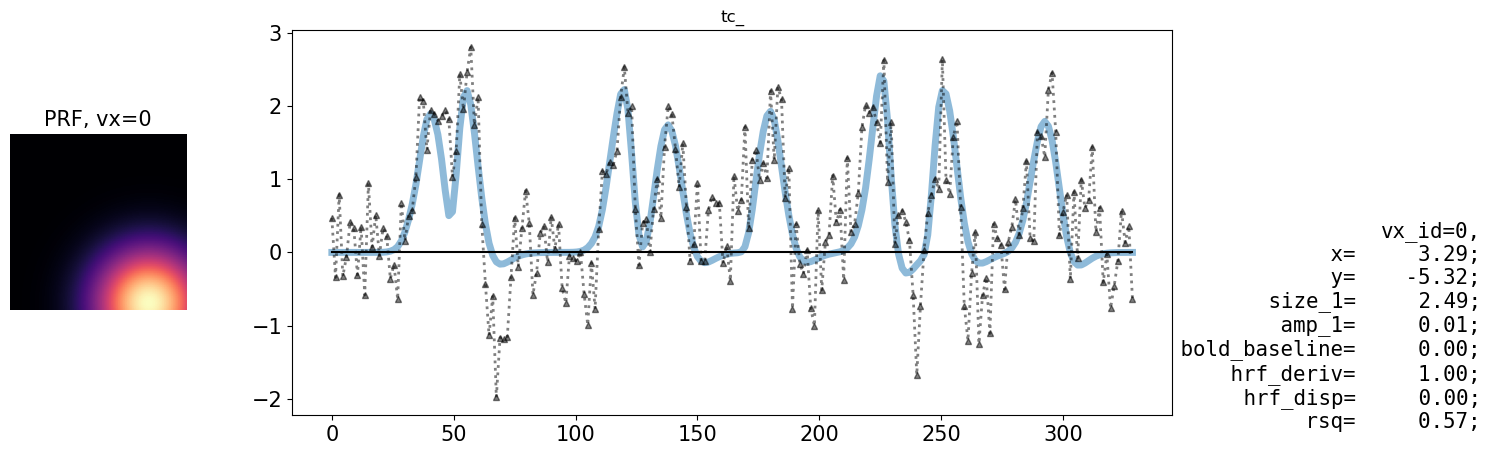

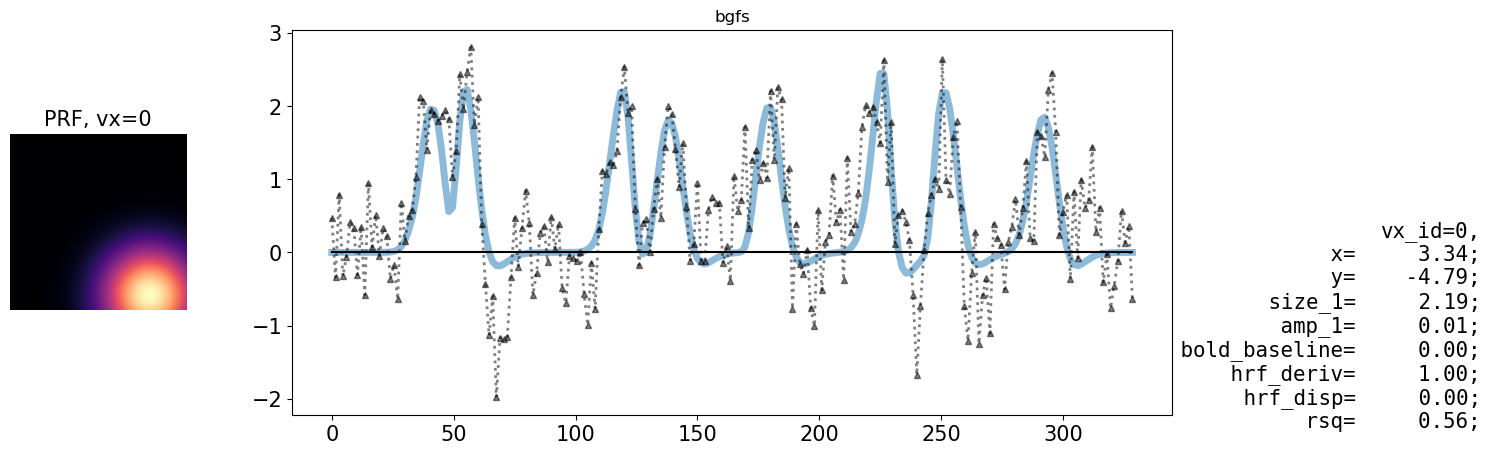

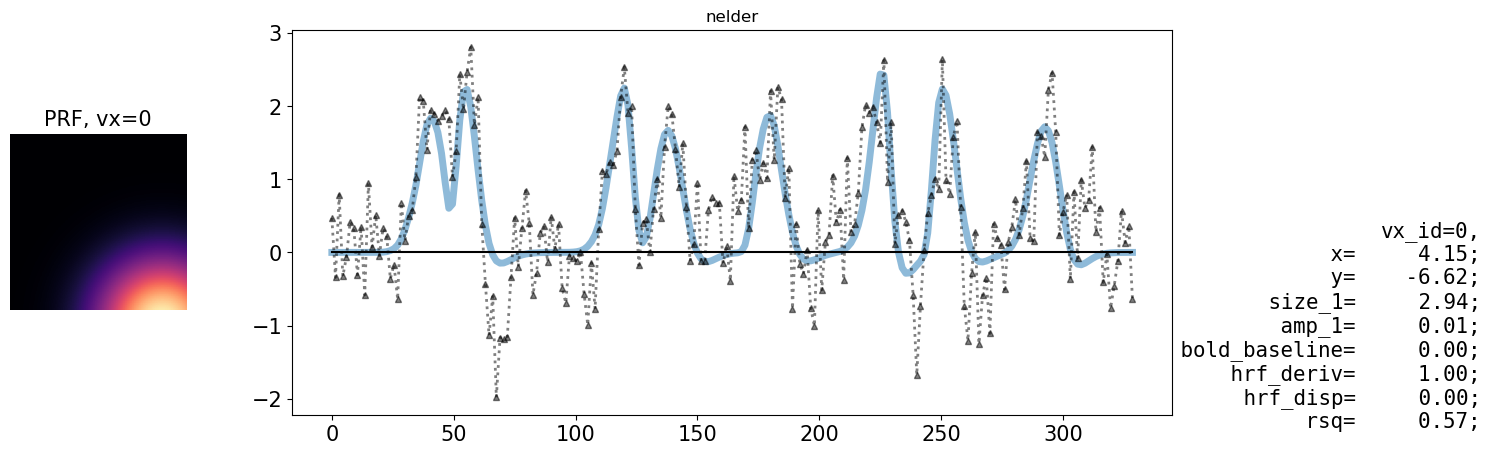

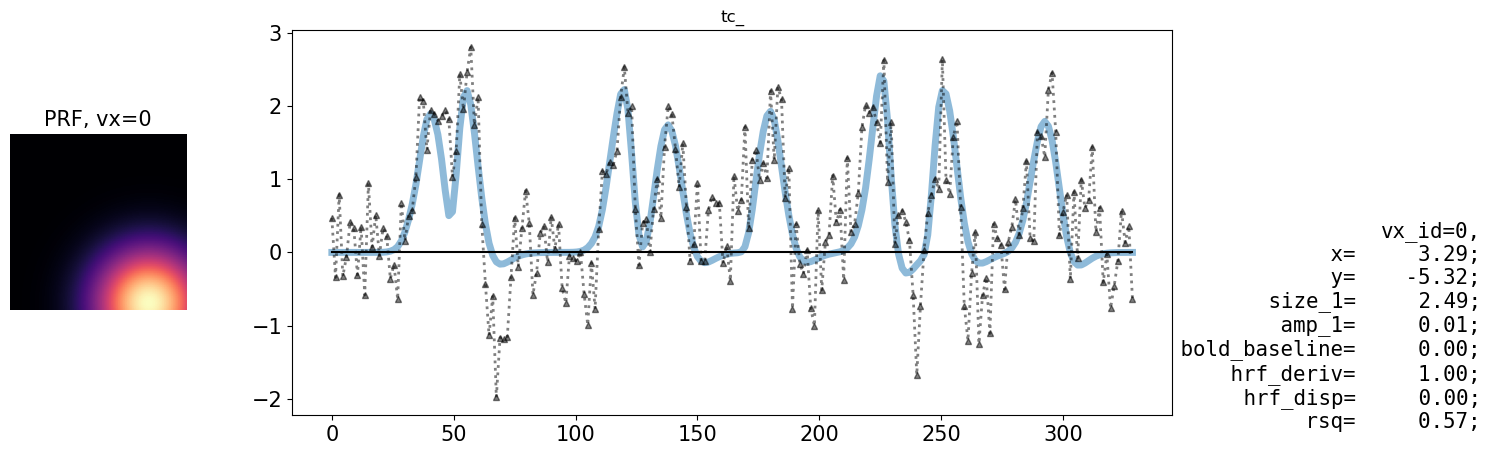

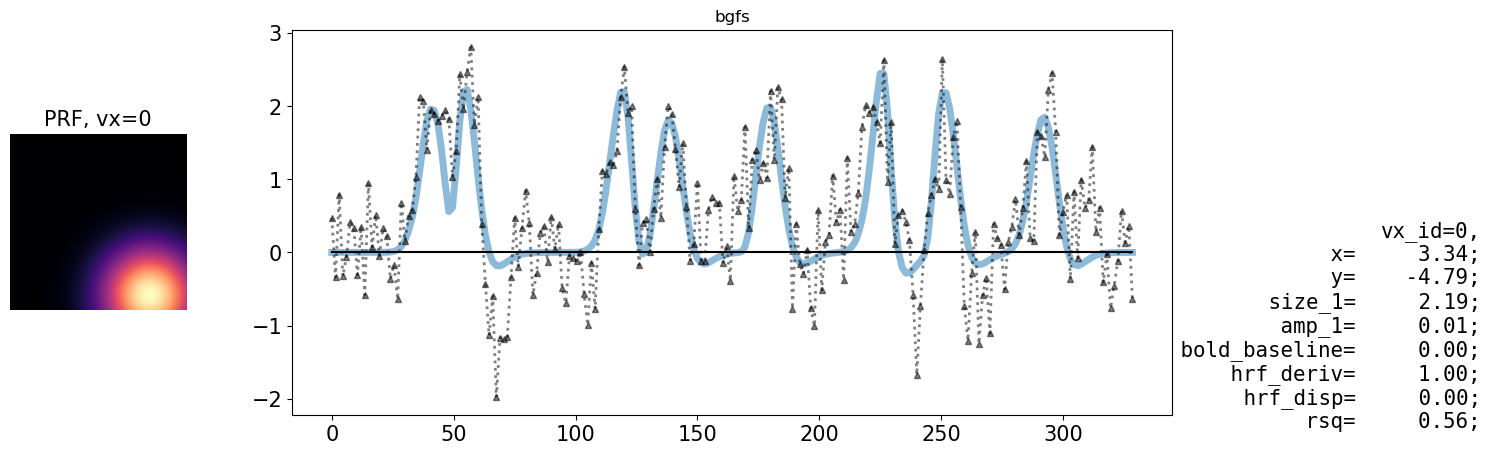

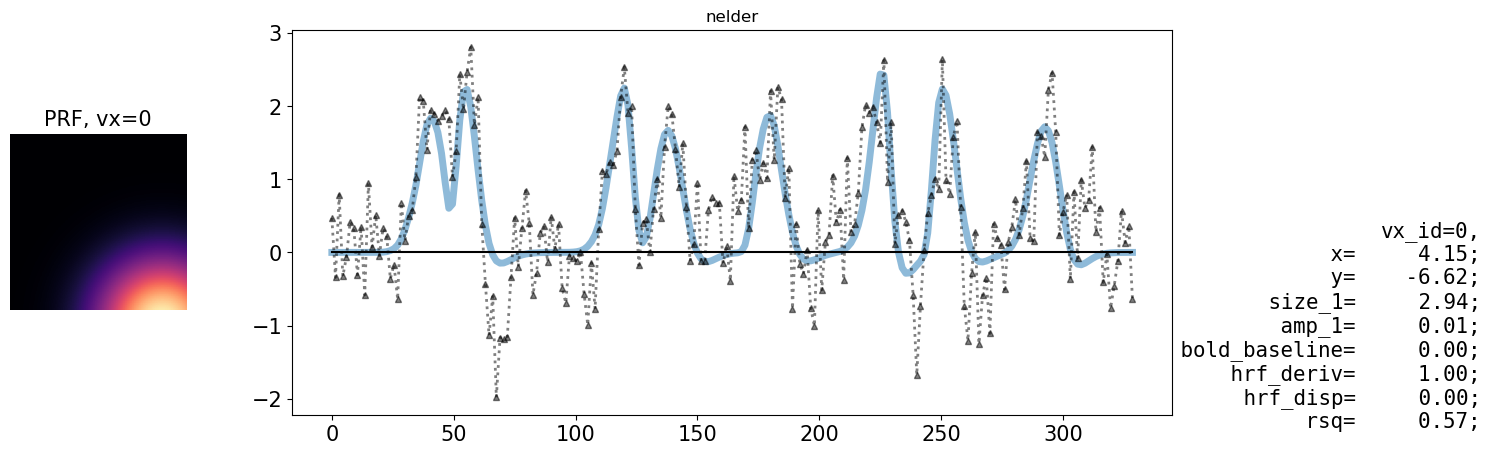

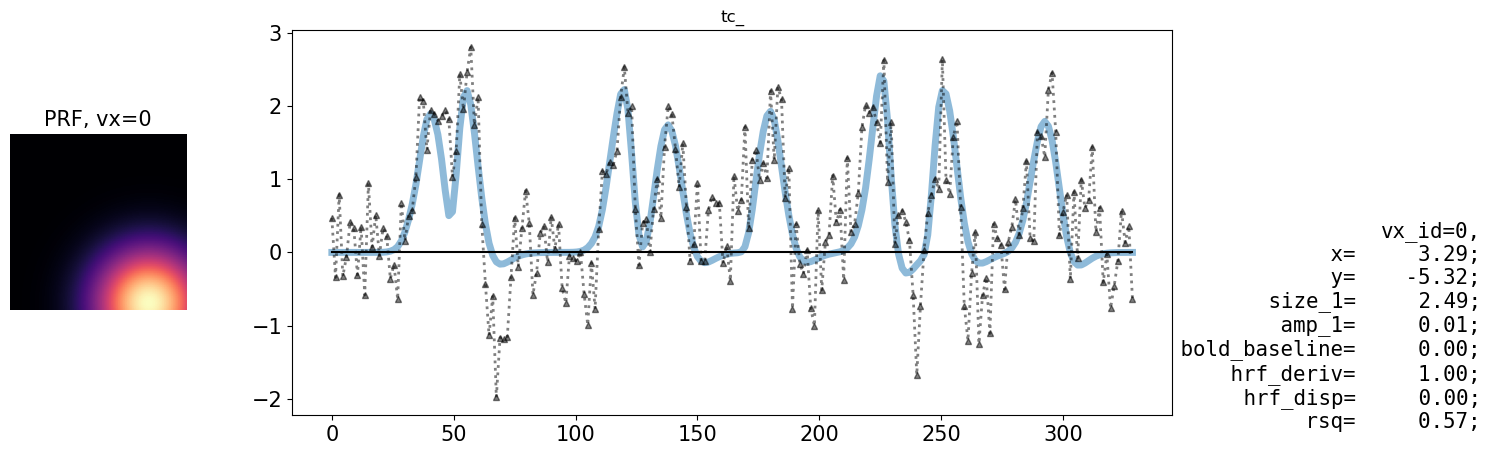

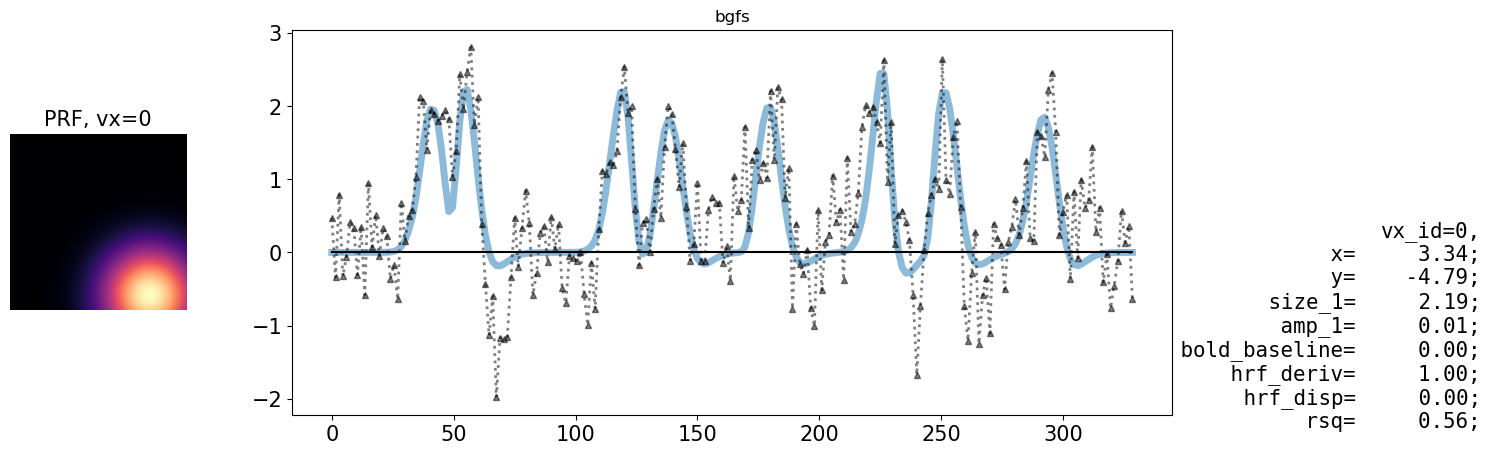

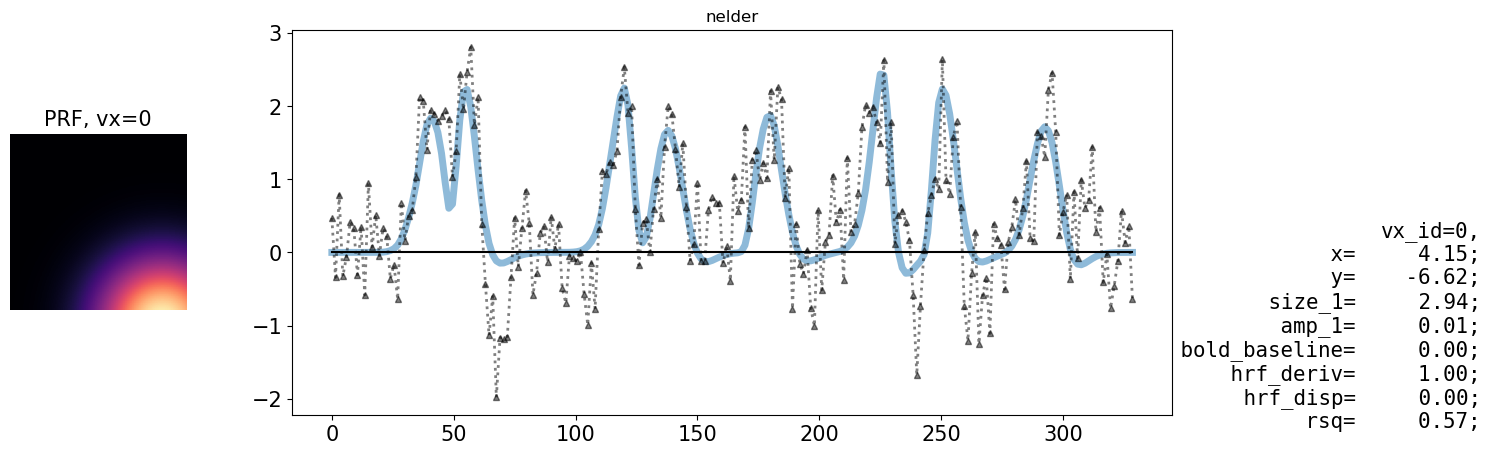

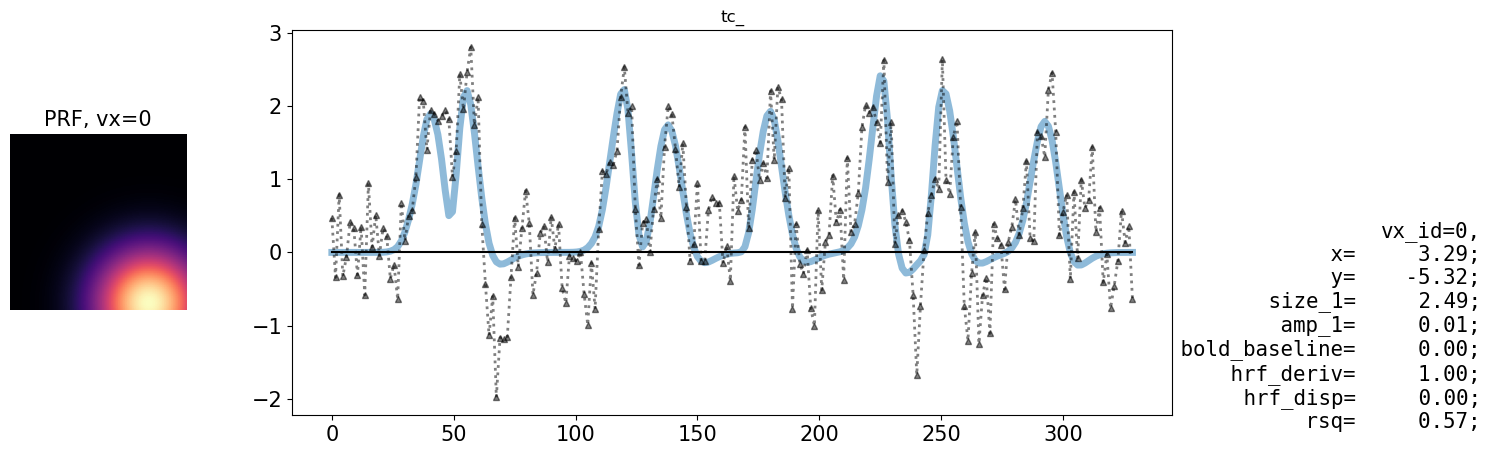

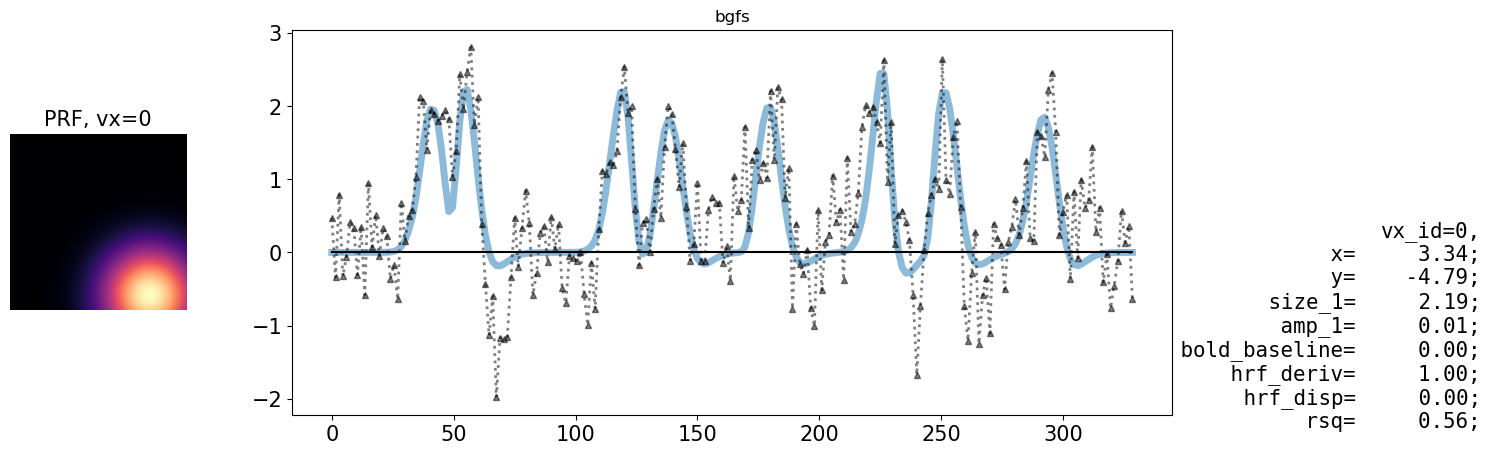

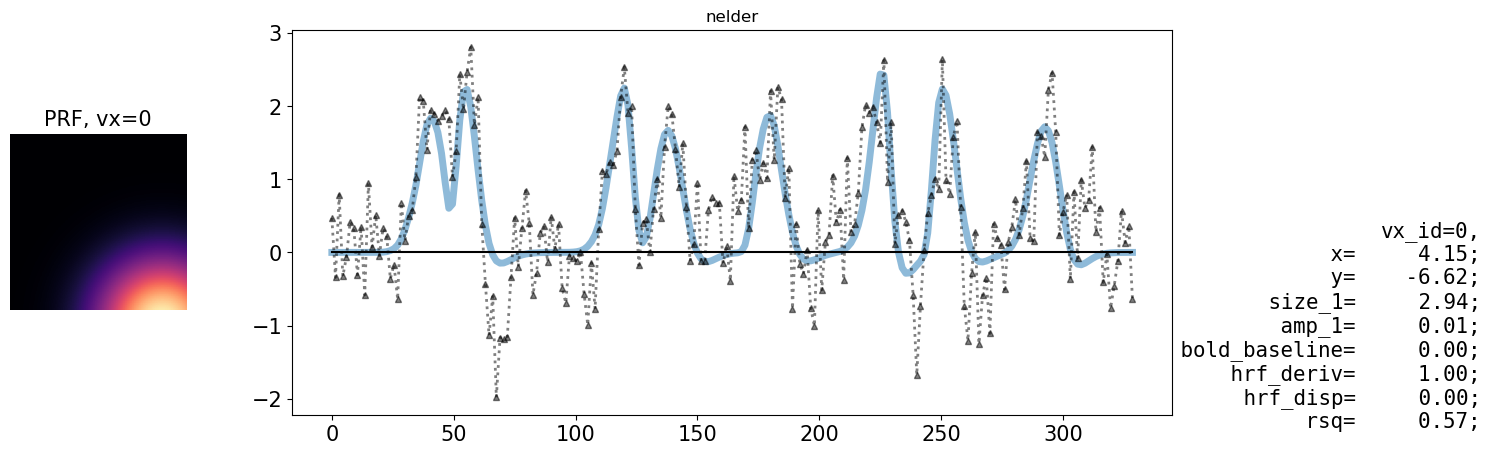

In [37]:
for ivx in [0, 100, 2000, 27]:
    for i in prf_multi[sub].prf_obj.keys():
        
        prf_multi[sub].prf_obj[i].prf_ts_plot(0)
        plt.title(i)
    

In [31]:
prf_multi[sub].prf_obj.values()[0]

TypeError: 'dict_values' object is not subscriptable

In [43]:
prf_objTC = TSPlotter(
    prf_params=prf_dataTC,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)
prf_objBG = TSPlotter(
    prf_params=prf_dataBG,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)
prf_objGR = TSPlotter(
    prf_params=prf_dataGR,
    model='gauss', 
    prfpy_model=gg,
    real_ts=ts_data,
)

prf_multi = PrfMulti(
    [prf_objBG, prf_objTC, prf_objGR], ['bg', 'tc', 'gr']
)


prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=8
include hrf = True
include rsq = True


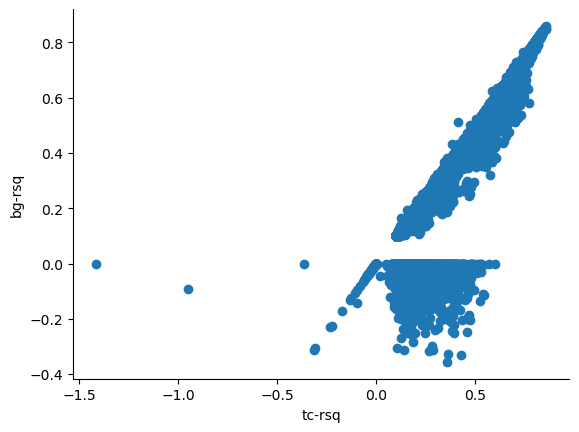

In [46]:
prf_multi.scatter('tc-rsq', 'bg-rsq', th={})

In [60]:
dag_make_custom_cmap(cmap_stack=['polar_starter', 'polar_starter_r'])
prf_multi.prf_obj['tc'].visual_field(dot_alpha=1, dot_size=1, dot_col='pol', dot_cmap='polar_starter', dot_vmin=-np.pi, dot_vmax=np.pi)

TypeError: dag_make_custom_cmap() got an unexpected keyword argument 'cmap_stack'